In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## Data Processing

In [2]:
data = pd.read_excel('amzn_net_sales.xlsx')
data.head()

,Quarter End,Amazon Net Sales
0,2000-03-31,0.57
1,2000-06-30,0.58
2,2000-09-30,0.64
3,2000-12-31,0.97
4,2001-03-31,0.70


In [3]:
data["Index"] = data.index
data.set_index('Quarter End', inplace=True)
data.head()

,Amazon Net Sales,Index
Quarter End,,
2000-03-31,0.57,0
2000-06-30,0.58,1
2000-09-30,0.64,2
2000-12-31,0.97,3
2001-03-31,0.70,4


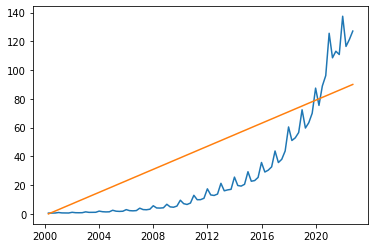

In [4]:
plt.plot(data)

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/2473159055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['Amazon Net Sales']
/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/2473159055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['Amazon Net Sales']


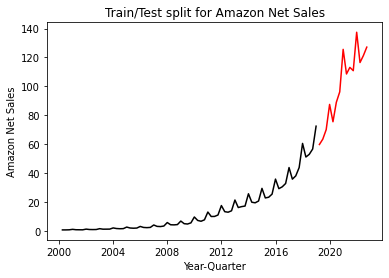

In [5]:
data['Date'] = data.index
train = data[data['Date'] < pd.to_datetime("2019-01", format='%Y-%m')]
train['train'] = train['Amazon Net Sales']
del train['Date']
del train['Amazon Net Sales']
test = data[data['Date'] >= pd.to_datetime("2019-01", format='%Y-%m')]
del test['Date']
test['test'] = test['Amazon Net Sales']
del test['Amazon Net Sales']
plt.plot(train['train'], color = "black")
plt.plot(test['test'], color = "red")
plt.title("Train/Test split for Amazon Net Sales")
plt.ylabel("Amazon Net Sales")
plt.xlabel('Year-Quarter')
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
test_stationarity(train['train'])

Results of Dickey-Fuller Test:
Test Statistic                  2.571972
p-value                         0.999069
#Lags Used                     12.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/2556688807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train_log'] = np.log(train['train'])


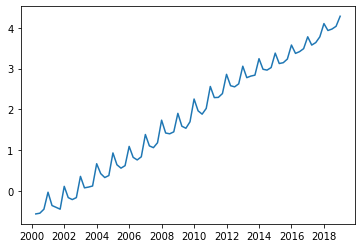

In [8]:
train['train_log'] = np.log(train['train'])
plt.plot(train['train_log'])

In [9]:
from scipy import stats

slope, intercept, r, p, std_err = stats.linregress(train['Index'], train['train_log'])
slope, intercept

(0.06397647107156486, -0.5996777491587137)

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/1420466928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['detrended_train_log'] = train['train_log'] - train['Index'] * slope - intercept


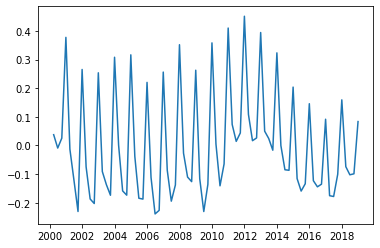

In [10]:
#detrend
train['detrended_train_log'] = train['train_log'] - train['Index'] * slope - intercept
plt.plot(train['detrended_train_log'])

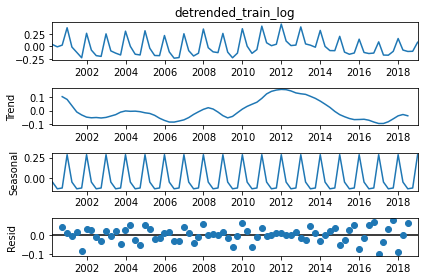

In [11]:
#deseason
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(train['detrended_train_log'])
decompose.plot()
plt.show()

## ARMA(p,q)

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/2987140581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['detrended_deseasoned_train_log'] = train['detrended_train_log'] - decompose.seasonal


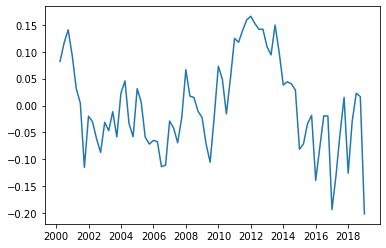

In [12]:
train['detrended_deseasoned_train_log'] = train['detrended_train_log'] - decompose.seasonal
plt.plot(train.index, train.detrended_deseasoned_train_log)

In [13]:
test_stationarity(train['detrended_deseasoned_train_log'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.236161
p-value                         0.193384
#Lags Used                      8.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


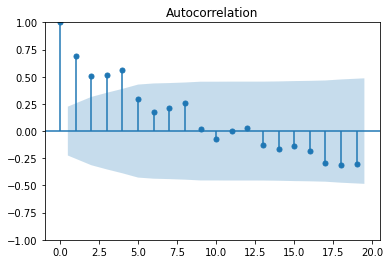

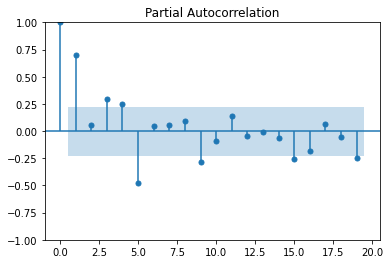

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train['detrended_deseasoned_train_log']);
plot_pacf(train['detrended_deseasoned_train_log']);

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['detrended_deseasoned_train_log'], order=(5,0,4))
res = model.fit()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/minifor

In [16]:
test['trended_test_log'] = test['Index'] * slope + intercept
test['seasoned_trended_test_log'] = test['trended_test_log'] + decompose.seasonal[test['Index']%4].to_list()
test['forecasted_seasoned_trended_test_log'] = test['seasoned_trended_test_log'] + res.forecast(15)
test['forecast'] = np.exp(test['forecasted_seasoned_trended_test_log'])

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3584605107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['trended_test_log'] = test['Index'] * slope + intercept
/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3584605107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['seasoned_trended_test_log'] = test['trended_test_log'] + decompose.seasonal[test['Index']%4].to_list()
/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3584605107.py:3: Sett

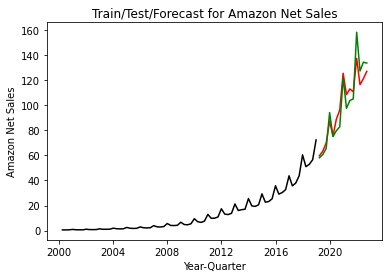

In [17]:
plt.plot(train['train'], color = "black")
plt.plot(test['test'], color = "red")
plt.plot(test['forecast'], color = "green")
plt.title("Train/Test/Forecast for Amazon Net Sales")
plt.ylabel("Amazon Net Sales")
plt.xlabel('Year-Quarter')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test['test'], test['forecast'])

90.5155858659657

## ARIMA (p,d,q)

### Check Stationary

In [19]:
test_stationarity(train['detrended_deseasoned_train_log'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.236161
p-value                         0.193384
#Lags Used                      8.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


### Select d & q

In [20]:
train['1_diff'] = train['detrended_deseasoned_train_log'].diff()
train['2_diff'] = train['detrended_deseasoned_train_log'].diff().diff()
train

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3681207104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['1_diff'] = train['detrended_deseasoned_train_log'].diff()
/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3681207104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['2_diff'] = train['detrended_deseasoned_train_log'].diff().diff()


,Index,train,train_log,detrended_train_log,detrended_deseasoned_train_log,1_diff,2_diff
Quarter End,,,,,,,
2000-03-31,0,0.57,-0.562119,0.037559,0.081914,NaN,NaN
2000-06-30,1,0.58,-0.544727,-0.009026,0.116159,0.034245,NaN
2000-09-30,2,0.64,-0.446287,0.025438,0.140887,0.024728,-0.009517
2000-12-31,3,0.97,-0.030459,0.377289,0.092300,-0.048587,-0.073315
2001-03-31,4,0.70,-0.356675,-0.012903,0.031452,-0.060847,-0.012260
...,...,...,...,...,...,...,...
2017-12-31,71,60.45,4.101817,0.159165,-0.125825,-0.140862,-0.208879
2018-03-31,72,51.04,3.932610,-0.074019,-0.029663,0.096162,0.237023
2018-06-30,73,52.89,3.968214,-0.102390,0.022795,0.052458,-0.043704


Text(0.5, 1.0, 'Autocorrelation of Original Time Series')

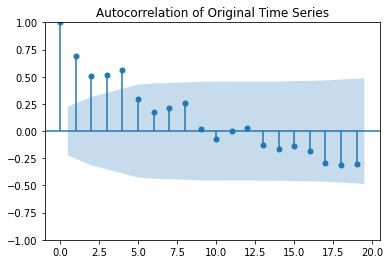

In [21]:
plot_acf(train['detrended_deseasoned_train_log']);
plt.title("Autocorrelation of Original Time Series")

Text(0.5, 1.0, 'Autocorrelation of First-Order Difference')

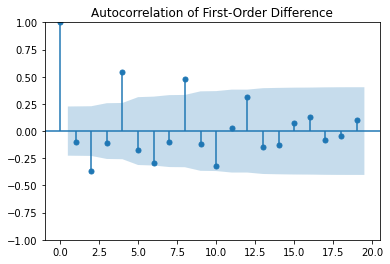

In [22]:
plot_acf(train['1_diff'].dropna())
plt.title("Autocorrelation of First-Order Difference")

Text(0.5, 1.0, 'Autocorrelation of Second-Order Difference')

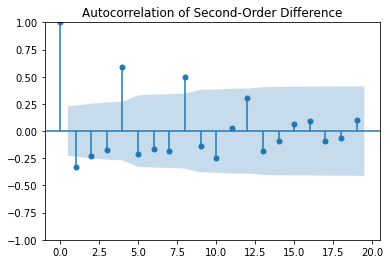

In [23]:
plot_acf(train['2_diff'].dropna())
plt.title("Autocorrelation of Second-Order Difference")

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3611850566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['d_detrended_deseasoned_train_log'] = train['detrended_deseasoned_train_log']-train['detrended_deseasoned_train_log'].shift()


Text(0.5, 1.0, 'Time Series (Detrending, De-seasoning, First Difference)')

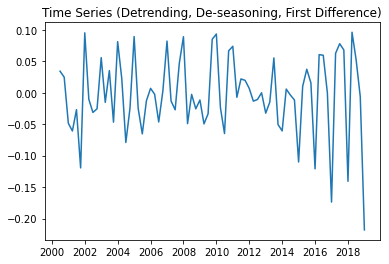

In [24]:
train['d_detrended_deseasoned_train_log'] = train['detrended_deseasoned_train_log']-train['detrended_deseasoned_train_log'].shift()
plt.plot(train.index, train.d_detrended_deseasoned_train_log)
plt.title("Time Series (Detrending, De-seasoning, First Difference)")

In [25]:
test_stationarity(train['d_detrended_deseasoned_train_log'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -3.403861
p-value                         0.010828
#Lags Used                      9.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


### Select p

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


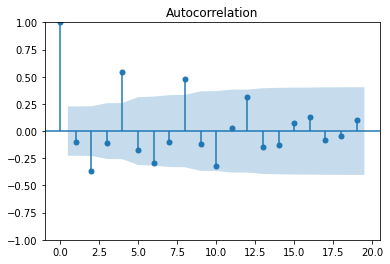

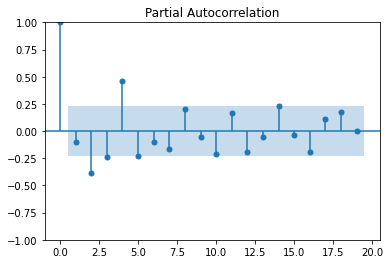

In [26]:
plot_acf(train['d_detrended_deseasoned_train_log'].dropna());
plot_pacf(train['d_detrended_deseasoned_train_log'].dropna());

### ARIMA Model

In [27]:
# ARIMA(4,1,4)
model_temp1 = ARIMA(train['d_detrended_deseasoned_train_log'].dropna(), order=(4,0,4))
res_temp1 = model_temp1.fit()
res_temp1.aic

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-233.41949226747175

In [28]:
# ARIMA(4,1,8)
model_temp2 = ARIMA(train['d_detrended_deseasoned_train_log'].dropna(), order=(4,0,8))
res_temp2 = model_temp2.fit()
res_temp2.aic

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/minifor

-233.67301361950592

In [29]:
# Final ARIMA(4,1,8)
model = ARIMA(train['d_detrended_deseasoned_train_log'].dropna(), order=(4,0,8))
res = model.fit()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/minifor

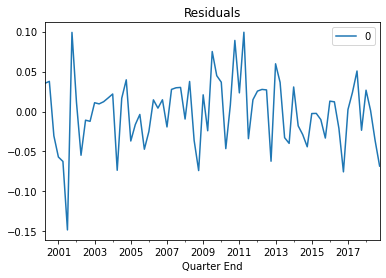

In [30]:
# Plot residual errors
residuals = pd.DataFrame(res.resid)
residuals.plot(title="Residuals")
plt.show()

<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

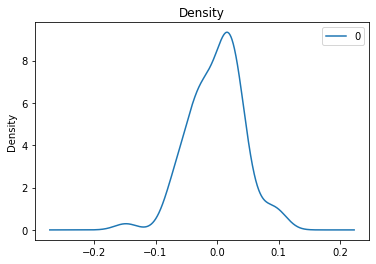

In [31]:
residuals.plot(kind='kde', title='Density')

### Prediction

In [32]:
d_detrended_deseasoned_log = train['d_detrended_deseasoned_train_log'].dropna()
d_detrended_deseasoned_log = d_detrended_deseasoned_log.append(res.forecast(15))

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/899155121.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_detrended_deseasoned_log = d_detrended_deseasoned_log.append(res.forecast(15))


In [33]:
test['trended_test_log'] = test['Index'] * slope + intercept
test['seasoned_trended_test_log'] = test['trended_test_log'] + decompose.seasonal[test['Index']%4].to_list()
test['forecasted_seasoned_trended_test_log'] = test['seasoned_trended_test_log'] + d_detrended_deseasoned_log.cumsum()[-15:]
test['forecast'] = np.exp(test['forecasted_seasoned_trended_test_log'])

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3401308466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['trended_test_log'] = test['Index'] * slope + intercept
/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3401308466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['seasoned_trended_test_log'] = test['trended_test_log'] + decompose.seasonal[test['Index']%4].to_list()
/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_19972/3401308466.py:3: Sett

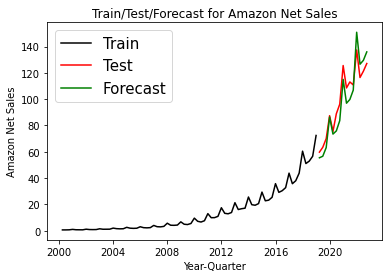

In [34]:
plt.plot(train['train'], color = "black", label = "Train")
plt.plot(test['test'], color = "red", label = "Test")
plt.plot(test['forecast'], color = "green", label = "Forecast")
plt.title("Train/Test/Forecast for Amazon Net Sales")
plt.ylabel("Amazon Net Sales")
plt.xlabel('Year-Quarter')
plt.legend(loc="upper left", fontsize = 15)
plt.show()

In [35]:
mean_squared_error(test['test'], test['forecast'])

87.40593919550102